---
layout: page
title: S&P 500
---

In [6]:
""" import library and package dependencies """
import sys
sys.path.insert(0, '../src')
import os
import datetime
import pytz
from collections import namedtuple

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.dates as mdates
from IPython.display import display, Markdown

from data_loader import load_data
from chart_format import Chart

The S&P 500 Index from Standard & Poor's is a market-capitalization-weighted index tracking the 500 largest publicly traded companies in the US. 

The S&P 500 is widely considered one of the best gauges of overall stock market performance because of its depth and diversity, tracking the top performing companies by market capitalization.

In [7]:
""" Load data
SPX ticker symbol is ^GSPC on Yahoo Finance 
"""
# Create a timezone object for New York
sx_tz = pytz.timezone('America/New_York')

from_date = datetime.datetime(1960, 1, 1) 
from_date = sx_tz.localize(from_date)

to_date = datetime.datetime.now().replace(hour=0, minute=0, second=0, microsecond=0)
to_date = sx_tz.localize(to_date)

csv_url = 'https://query1.finance.yahoo.com/v7/finance/download/%5EGSPC?period1=' + str(int(from_date.timestamp())) + '&period2=' + str(int(to_date.timestamp())) + '&interval=1d&events=history&includeAdjustedClose=true'
local_file = '../data/spx_HistoricalData.csv'
max_age_days = 7

df = load_data(csv_url, local_file, max_age_days)

In [8]:
""" Data Transformation """
data_column = 'Adj Close'
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

# Set 'last_index' to the last date with a valid value (so I can display 'as of <date>' in chart title)
last_index = df[data_column].last_valid_index() # pandas timestamp


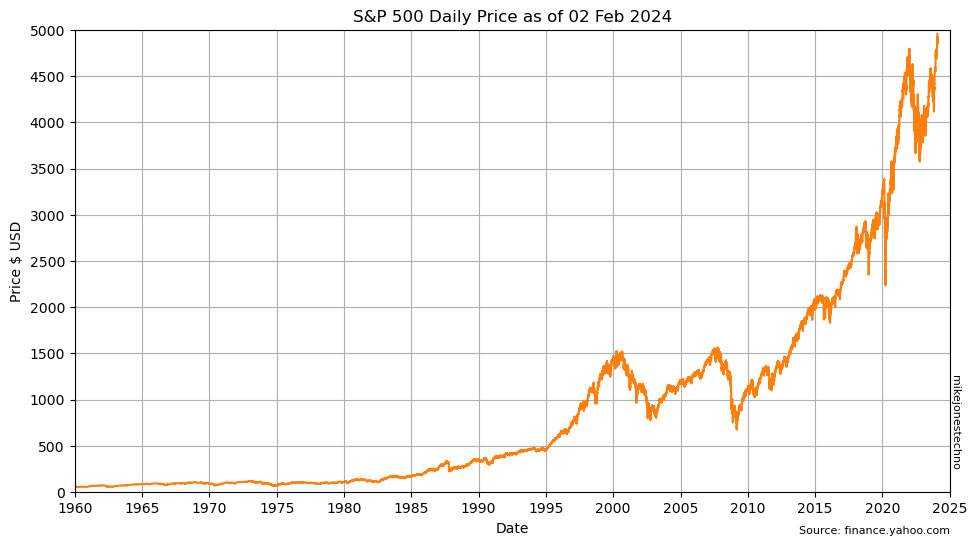

In [9]:
""" Show simple chart """

simple_chart = Chart(
    chart_title='S&P 500 Daily Price as of ' + last_index.strftime('%d %b %Y'), 
    chart_source='Source: finance.yahoo.com', 
    y_label='Price $ USD', 
    y_ticks=500,
    x_label='Date', 
    x_ticks=5,
    data_column=data_column
)
plt, colors = simple_chart.base_chart(df)

plt.plot(df.index, df[data_column], color=colors[1]['color'])

plt.show()

The compound annual growth over time appears to be an exponential curve. Plotting the same data with a logarithmic y-axis scale helps visualize the bursts of growth in earlier years that would otherwise be hidden by the volatility of spikes in later years.

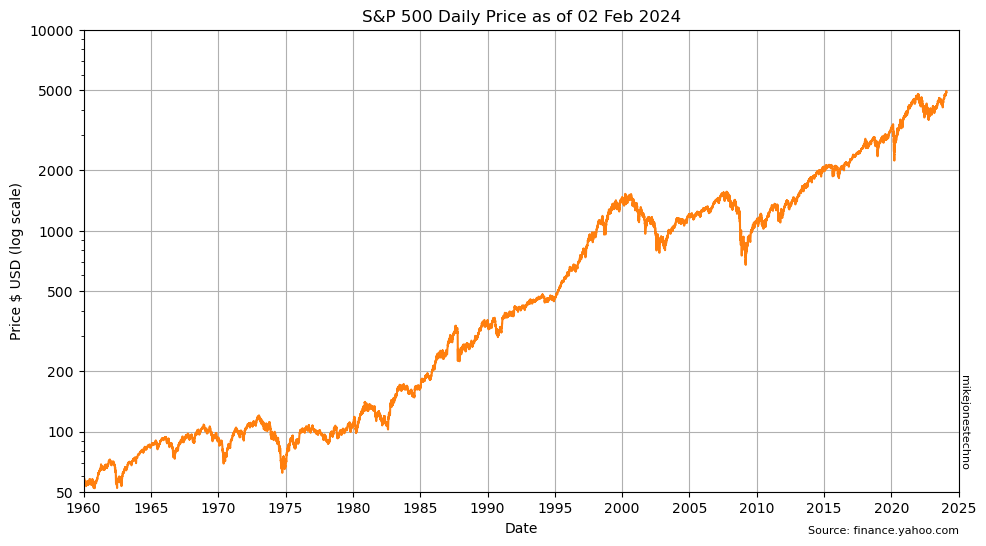

In [10]:
""" y-axis log scale """
log_chart = Chart(
    chart_title = simple_chart.chart_title, 
    chart_source = simple_chart.chart_source, 
    y_label = simple_chart.y_label + ' (log scale)', 
    y_log = True,
    y_log_ticks = [50, 100, 200, 500, 1000, 2000, 5000, 10000],
    x_label = simple_chart.x_label, 
    x_ticks = simple_chart.x_ticks
)
plt, colors = log_chart.base_chart(df)
plt.plot(df.index, df[data_column], color=colors[1]['color'])

plt.show()

The logarithmic scale shows a period of volatility between 1965 and 1980 where the price was flat, trending very slightly up.

The sudden almost 45' angle from 1980 shows significant growth, climbing 10x over 20 years, from $100 in 1980 to over $1,000 in the year 2000. 

The S&P 500 hit a ten year period of volatility between 2000 and 2010 which wiped out almost 1/2 of the value at the lowest point.

Another 45' climb over the next 15 years resulted in another 5x from $1,000 in 2010 to $5,000 around 2025.

The logarithmic scale shows the S&P 500 has consistent multi-year periods of high growth performance (with flat sideways trends through periods of high volatility).


In [11]:
""" Year over Year (YoY) change based on 252 trading days per year """
annual_trading_days = 252
df['YoY'] = df[data_column].pct_change(periods=annual_trading_days)*100

""" Calculate median 50th and lower, upper percentiles over multiple years """
periods_per_year = annual_trading_days
multi_year = 10
multi_year_extended = 3

# Define the percentiles and window sizes
Percentiles = namedtuple('Percentiles', ['lower', 'median', 'upper'])
percentiles = Percentiles(25, 50, 75)

window_periods = [
    periods_per_year,
    periods_per_year * multi_year,
    periods_per_year * multi_year * multi_year_extended
]

def add_percentiles(df, column, window, prefix):
    """Calculate and add percentiles to the DataFrame for a given window size."""
    for percentile_name, percentile in zip(percentiles._fields, percentiles):
        df[f'{prefix}_{percentile_name}'] = df[column].rolling(window=window).quantile(percentile/100)

# Calculate and add the percentiles for each window size
for window in window_periods:
    years = window // periods_per_year
    name = f'rolling_{years}_years'
    add_percentiles(df, 'YoY', window, name)

In [12]:
""" Create a markdown data table of the multi year percentiles to reuse in other notebooks """

# Create the header rows of the table
table = "| Years |   " + " |   ".join(f'{str(percentile)}' for percentile in percentiles) + " |\n"
table += "|-------" + "|-----:" * len(Percentiles._fields) + "|\n"

# Add the percentile values for each window period
for window in window_periods:
    years = window // periods_per_year
    name = f'rolling_{years}_years'
    table += f"| {str(years).ljust(5)} | " + " | ".join("{:,.2f}".format(df[f'{name}_{percentile_name}'].iloc[-1]) for percentile_name in Percentiles._fields) + " |\n"


In [13]:
display(Markdown(f"""
Calculating the {percentiles[0]}th and {percentiles[2]}th percentile over a multi-year time horizon helps smooth out the anomolies and visualize the {Percentiles._fields[0]} and {Percentiles._fields[2]} long term trends.
"""))


Calculating the 25th and 75th percentile over a multi-year time horizon helps smooth out the anomolies and visualize the lower and upper long term trends.


In [14]:
# Replace headings for percentile column headings
headings = table.split('\n')[0].split('|')[2:-1]
updated_headings = [ heading.strip() + 'th percentile' for heading in headings]
updated_headings_row = '| Years | ' + ' | '.join(updated_headings) + ' |'
show_table = table.replace(table.split('\n')[0], updated_headings_row, 1)

display(Markdown(f"""
Over the last {multi_year} years the {Percentiles._fields[1]} ({percentiles[1]}th percetile) change is { "{:,.2f}".format(df[f'rolling_{multi_year}_years_{Percentiles._fields[1]}'].iloc[-1])  }%.

Over the last {multi_year * multi_year_extended} years the {Percentiles._fields[1]} ({percentiles[1]}th percetile) change is { "{:,.2f}".format(df[f'rolling_{multi_year * multi_year_extended}_years_{Percentiles._fields[1]}'].iloc[-1])  }%.

{show_table}
"""))


Over the last 10 years the median (50th percetile) change is 12.34%.

Over the last 30 years the median (50th percetile) change is 11.51%.

| Years | 25th percentile | 50th percentile | 75th percentile |
|-------|-----:|-----:|-----:|
| 1     | -0.50 | 12.06 | 16.36 |
| 10    | 2.67 | 12.34 | 17.39 |
| 30    | 1.29 | 11.51 | 19.55 |



In [15]:
def plot_percentiles(df, percentiles, multi_year):
    """
    Plots the percentiles of the YoY Annual Price Change for a given DataFrame.

    Parameters:
    - df: DataFrame must contain col named "rolling_{multi_year}_years_{percentile}" eg "rolling_10_years_median"
    - percentiles: tuple - A tuple of three integers representing the percentiles to be plotted.
    - multi_year: int - The number of years for which the percentile is calculated.

    # Define the percentiles and window sizes like this:
    Percentiles = namedtuple('Percentiles', ['lower', 'median', 'upper'])
    percentiles = Percentiles(25, 50, 75)

    Returns:
    None
    """
    plt.figure(figsize=(10, 6))
    plt.plot(df.index, df['YoY'], label='YoY Annual Price Change', color=colors[1]['color'], alpha=0.1)

    for i, percentile in enumerate(Percentiles._fields):
        linestyle = '--' if i != 1 else '-'
        alpha = 0.7 if i != 1 else 1.0
        if i == 0:
            label = f'{str(percentiles[0]) + "th and " + str(percentiles[2]) + "th Percentile"}'
        elif i == 1:
            label = f'{multi_year} Year {percentile.capitalize()}'
        else:
            label = None
        plt.plot(df.index, df[f'rolling_{multi_year}_years_{percentile}'], color=colors[1]['color'], linestyle=linestyle, alpha=alpha, label=label)

    plt.xlabel(simple_chart.x_label)
    plt.ylabel(y_label)
    plt.title(chart_title)
    plt.figtext(1, 0.01, chart_source, ha="right", fontsize=8)
    plt.subplots_adjust(right=1)  # Reset right boundary of the subplots after adding figtext
    plt.ylim(bottom=bottom_limit, top=top_limit) 
    plt.xlim(left=left_limit, right=right_limit)
    ax = plt.gca()  # Get the current Axes instance
    ax.xaxis.set_major_locator(mdates.YearLocator(tick_years))  # Set major ticks every x years
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))  # Format major ticks as years
    ax.yaxis.set_major_locator(ticker.MultipleLocator(y_ticks))
    if len(ax.get_xticks()) > 15:
        plt.xticks(rotation=45)  # Rotate x-axis labels
        plt.subplots_adjust(bottom=0.13)  # Reset bottom boundary of the subplots after rotating text
    plt.grid(True)

    # Create the legend with the existing entries and the new patch
    legend = plt.legend(loc=legend_location)
    legend.get_frame().set_alpha(0.98)
    plt.show()

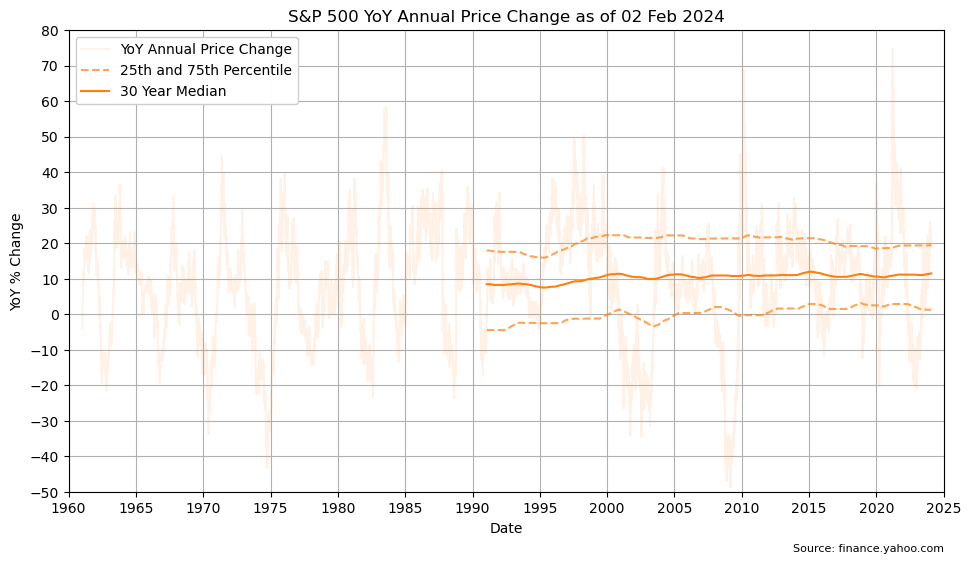

In [16]:
y_label = 'YoY % Change'
legend_location = 'upper left'
tick_years = x_years = simple_chart.x_ticks
end_year = (df.index[-1].year // x_years) * x_years + x_years
right_limit = pd.to_datetime(f'{end_year}-01-01')
start_year = (df.index[0].year // x_years) * x_years
left_limit = pd.to_datetime(f'{start_year}-01-01')
chart_title = 'S&P 500 YoY Annual Price Change as of ' + last_index.strftime('%d %b %Y')
chart_source = simple_chart.chart_source
bottom_limit = -50
top_limit = 80
y_ticks = 10
plot_percentiles(df, percentiles, multi_year*multi_year_extended)

> ℹ Given the multi-decade history, the data suggests high confidence using a baseline stock market performance of 12% with some uncertainty or risk that stocks can go up or down for several years at a time. Note this does not take inflation into consideration.

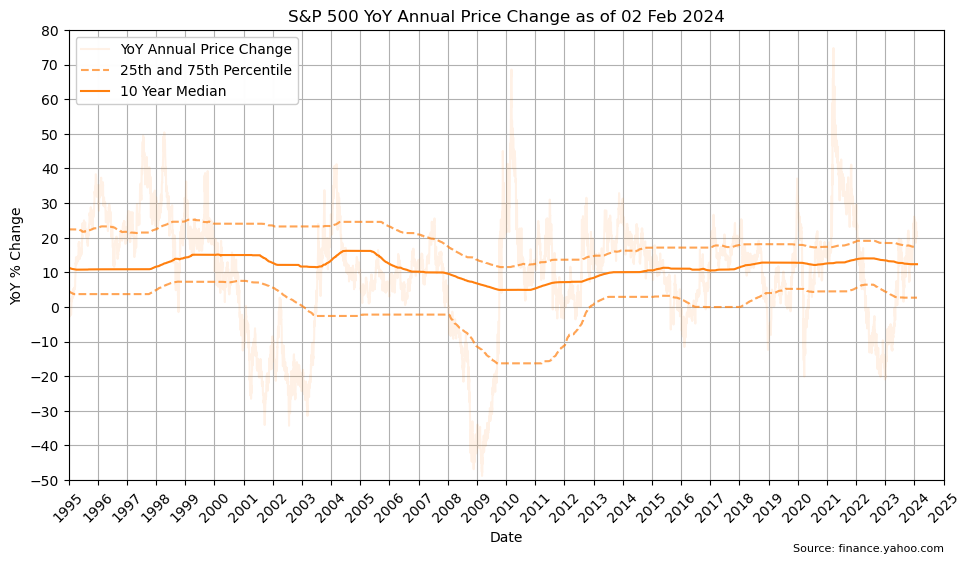

In [17]:
""" Change chart variables to plot from 1995 and multi year window not extended multi year window """
left_limit = pd.to_datetime('1995-01-01')
tick_years = 1
#legend_location = 'upper center'

plot_percentiles(df, percentiles, multi_year)

In [18]:
## TODO: Add an overlay of inflation - super funds often set a target of 2.5 - 3.5% above inflation 10 year average
## TODO: Add opinion on the relative strong performance of S&P 500, and inclusion of high profit stocks, regardless of personal ethics or values? 